In [13]:
# =============================================
# 0) Import & Global Settings
# =============================================
import os, json, warnings, math, re
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import lightgbm as lgb
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Ï∂úÎ†• ÏòµÏÖò
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)

# ÌïúÍ∏Ä Ìè∞Ìä∏ (macOS)
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

FILE_PATH = "./data/data.csv"
PROD_COL  = "Product_Number"
DT_COL    = "DateTime"

In [14]:
# ---------------------------------------------
# Í≥µÌÜµ Ïú†Ìã∏
# ---------------------------------------------
def read_csv_safely(path):
    for enc in ("utf-8", "cp949"):
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            continue
    # ÏµúÌõÑ: Ïù∏ÏΩîÎî© Ï∂îÏ†ï Ïã§Ìå® Ïãú Í∏∞Î≥∏
    return pd.read_csv(path)

def to_float_series(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s.astype(str).str.replace(",", ""), errors="coerce")

def basic_overview(df):
    info = {
        "rows": df.shape[0],
        "cols": df.shape[1],
        "memory_mb": round(df.memory_usage(deep=True).sum() / (1024**2), 3),
        "nunique": df.nunique().to_dict(),
        "dtypes": df.dtypes.astype(str).to_dict(),
    }
    print(json.dumps(info, indent=2, ensure_ascii=False))

def parse_datetime_col(df, col=DT_COL):
    s = df[col].astype(str).str.strip()
    parsed = pd.to_datetime(s, format="%Y-%m-%d %H:%M:%S", errors="coerce")
    m = parsed.isna() & s.notna()
    if m.any():
        parsed.loc[m] = pd.to_datetime(s.loc[m], errors="coerce")
    df[col] = parsed
    print(f"{col} Î≥ÄÌôò ÏôÑÎ£å | Í≤∞Ï∏°Ïπò={df[col].isna().sum()} | dtype={df[col].dtype}")
    return df

def iqr_bounds(x, q1=0.25, q3=0.75, k=1.5):
    Q1, Q3 = x.quantile(q1), x.quantile(q3)
    IQR = Q3 - Q1
    return Q1 - k*IQR, Q3 + k*IQR

In [15]:
# =============================================
# 1) Load & Í∏∞Î≥∏ Ï†êÍ≤Ä
# =============================================
df = read_csv_safely(FILE_PATH)
print("shape:", df.shape)
print("columns:", df.columns.tolist()[:15], "...")

basic_overview(df)

# DateTime Î≥ÄÌôò
df = parse_datetime_col(df, DT_COL)

# ÏïàÏ†ÑÌïú ÏàòÏπòÌòï Ïª¨Îüº ÏãùÎ≥Ñ
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

# 0/ÎπÑ0 ÎπÑÏú® (ÏàòÏπòÌòï ÎåÄÏÉÅ)
zero_ratio = (df[num_cols] == 0).sum() / len(df)
ratio_df = pd.DataFrame({"Zero_Ratio": zero_ratio, "NonZero_Ratio": 1 - zero_ratio}).sort_values("Zero_Ratio", ascending=False)
display(ratio_df.head(20))

# Í≤∞Ï∏°Ïπò ÏöîÏïΩ
na_summary = df.isna().sum().sort_values(ascending=False).to_frame("na_count")
na_summary["na_rate"] = na_summary["na_count"] / len(df)
display(na_summary.head(20))

# Í∏∞Ïà†ÌÜµÍ≥Ñ(ÏàòÏπòÌòï)
display(df[num_cols].describe().T)

shape: (34617, 20)
columns: ['Product_Number', 'TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ', 'T+1Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ', 'T+2Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ', 'T+3Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ', 'T+4Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ', 'ÏûëÎÖÑ TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ', 'ÏûëÎÖÑ T+1Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ', 'ÏûëÎÖÑ T+2Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ', 'ÏûëÎÖÑ T+3Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ', 'ÏûëÎÖÑ T+4Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ', 'TÏùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ', 'T+1Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ', 'T+2Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ', 'T+3Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ'] ...
{
  "rows": 34617,
  "cols": 20,
  "memory_mb": 10.469,
  "nunique": {
    "Product_Number": 117,
    "TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ": 481,
    "T+1Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ": 366,
    "T+2Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ": 360,
    "T+3Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ": 372,
    "T+4Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ": 373,
    "ÏûëÎÖÑ TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ": 381,
    "ÏûëÎÖÑ T+1Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ": 365,
    "ÏûëÎÖÑ T+2Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ": 411,
    "ÏûëÎÖÑ T+3Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ": 385,
    "ÏûëÎÖÑ T+4Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ": 377,
    "TÏùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ": 378,
    "T+1Ïùº ÏòàÏÉÅ 

Zero_Ratio  NonZero_Ratio
T+2Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ       0.582459       0.417541
ÏûëÎÖÑ T+4Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ    0.563105       0.436895
T+3Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ       0.558772       0.441228
T+4Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ       0.491637       0.508363
ÏûëÎÖÑ TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ      0.478493       0.521507
TÏùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ         0.448046       0.551954
T+2Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ       0.439755       0.560245
T+4Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ       0.437242       0.562758
T+1Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ       0.429413       0.570587
T+1Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ       0.423116       0.576884
ÏûëÎÖÑ T+1Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ    0.417107       0.582893
T+3Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ       0.397926       0.602074
ÏûëÎÖÑ T+3Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ    0.382702       0.617298
ÏûëÎÖÑ T+2Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ    0.269405       0.730595
TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ         0.193344       0.806656
Temperature       0.000000       1.000000
Humidity          0.000000       1.000000

na_count  na_rate
Product_Number         0      0.0
TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ              0      0.0
Temperature            0      0.0
DoW                    0      0.0
DateTime               0      0.0
T+4Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ            0      0.0
T+3Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ            0      0.0
T+2Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ            0      0.0
T+1Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ            0      0.0
TÏùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ              0      0.0
ÏûëÎÖÑ T+4Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ         0      0.0
ÏûëÎÖÑ T+3Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ         0      0.0
ÏûëÎÖÑ T+2Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ         0      0.0
ÏûëÎÖÑ T+1Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ         0      0.0
ÏûëÎÖÑ TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ           0      0.0
T+4Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ            0      0.0
T+3Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ            0      0.0
T+2Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ            0      0.0
T+1Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ            0      0.0
Humidity               0      0.0

count        mean         std        min        25%  \
TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ       34617.0  101.468267  168.004255   0.000000   2.000000   
T+1Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ     34617.0   67.014039  131.212735   0.000000   0.000000   
T+2Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ     34617.0   48.758298  115.200052   0.000000   0.000000   
T+3Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ     34617.0   51.888552  115.111868   0.000000   0.000000   
T+4Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ     34617.0   60.855822  123.274794   0.000000   0.000000   
ÏûëÎÖÑ TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ    34617.0   63.709969  127.469879   0.000000   0.000000   
ÏûëÎÖÑ T+1Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ  34617.0   70.922726  133.088260   0.000000   0.000000   
ÏûëÎÖÑ T+2Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ  34617.0   89.926568  146.436175   0.000000   0.000000   
ÏûëÎÖÑ T+3Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ  34617.0   76.280642  138.961635   0.000000   0.000000   
ÏûëÎÖÑ T+4Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ  34617.0   55.156339  120.926792   0.000000   0.000000   
TÏùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ       34617.0   71.217870  134.573815   0.000000   0.000000   
T+1Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ     34617.0   73.145449  135.423466   0.000000   0.000000   
T+2Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ     34617.0   71.893405  135.460234   0.000000   0.000000   
T+3Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ     34617.0   77.254817  138.454265   0.000000   0.000000   
T+4Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ     34617.0   76.309183  138.171414   0.000000   0.000000   
Temperature     34617.0   18.059813    5.221529   8.190541  13.410000   
Humidity        34617.0   35.617655   80.929572  11.530000  21.799474   

                      50%         75%          max  
TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ       30.000000  124.000000  1131.000000  
T+1Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ      5.000000   69.000000   883.000000  
T+2Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ      0.000000   36.000000   885.000000  
T+3Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ      0.000000   44.000000   872.000000  
T+4Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ      1.000000   62.000000   865.000000  
ÏûëÎÖÑ TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ     1.000000   67.000000   863.000000  
ÏûëÎÖÑ T+1Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ   8.000000   79.000000   909.000000  
ÏûëÎÖÑ T+2Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ  28.000000  109.000000   912.000000  
ÏûëÎÖÑ T+3Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ  11.000000   88.000000   909.000000  
ÏûëÎÖÑ T+4Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ   0.000000   49.000000   886.000000  
TÏùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ        5.000000   82.000000   839.000000  
T+1Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ      8.000000   88.000000   896.000000  
T+2Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ      5.000000   80.000000   794.000000  
T+3Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ     10.000000   88.000000   926.000000  
T+4Ïùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ      6.000000   87.000000   969.000000  
Temperature     19.543931   22.516691    27.595882  
Humidity        28.932168   37.060000  1021.615319

In [16]:
# =============================================
# 2) DateTime Í∏∞Í∞Ñ Ï∂îÏ∂ú + Ï§ëÎ≥µ ÌôïÏù∏
# =============================================

# ÏµúÏÜå~ÏµúÎåÄ Í∏∞Í∞Ñ Ï∂îÏ∂ú
start_date = df['DateTime'].min()
end_date = df['DateTime'].max()

print(f"Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ: {start_date:%Y-%m-%d %H:%M} ~ {end_date:%Y-%m-%d %H:%M}")

# Ï¥ù Í∏∞Í∞Ñ Ï∂îÏ∂ú
duration = end_date - start_date
print(f"Ï¥ù Í∏∞Í∞Ñ: {duration.days}Ïùº ({duration.days/30:.1f}Í∞úÏõî)")

# Ï†úÌíà ÌÇ§
prod_col = "Product_Number" if "Product_Number" in df.columns else None

# ÏôÑÏ†Ñ Ï§ëÎ≥µ Ìñâ
dup_all = df.duplicated().sum()
print("ÏôÑÏ†Ñ Ï§ëÎ≥µ Ìñâ Ïàò:", dup_all)

# (Ï†úÌíà, ÎÇ†Ïßú) Ï§ëÎ≥µ
if prod_col and 'DateTime':
    dup_key = df.duplicated(subset=[prod_col, 'DateTime']).sum()
    print(f"({prod_col}, {'DateTime'}) Í∏∞Ï§Ä Ï§ëÎ≥µ Ïàò:", dup_key)

Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ: 2022-01-26 18:30 ~ 2022-05-11 07:04
Ï¥ù Í∏∞Í∞Ñ: 104Ïùº (3.5Í∞úÏõî)
ÏôÑÏ†Ñ Ï§ëÎ≥µ Ìñâ Ïàò: 2
(Product_Number, DateTime) Í∏∞Ï§Ä Ï§ëÎ≥µ Ïàò: 723


In [17]:
# =============================================
# 3) ÌíàÏßà/ÏÑºÏÑú Î≥ÄÏàò Ï†êÍ≤Ä + Ïù¥ÏÉÅÏπò Ïª∑ÌåÖ
# =============================================
for c in ["Humidity", "Temperature"]:
    if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
        lo, hi = iqr_bounds(df[c].dropna())
        n_lo = int((df[c] < lo).sum()); n_hi = int((df[c] > hi).sum())
        print(f"[{c}] IQR ÌïòÌïú={lo:.3f}, ÏÉÅÌïú={hi:.3f}, Ï†ÄÌïòÌïú={n_lo}, Í≥†ÏÉÅÌïú={n_hi}, max={df[c].max():.3f}")

# ÎèÑÎ©îÏù∏ Ïª∑ÌåÖ: Humidity(0~100)
if "Humidity" in df.columns:
    before_max = df["Humidity"].max()
    df["Humidity"] = df["Humidity"].clip(0, 100)
    after_max = df["Humidity"].max()
    print(f"Humidity clip: {before_max} ‚Üí {after_max}")

[Humidity] IQR ÌïòÌïú=-1.091, ÏÉÅÌïú=59.951, Ï†ÄÌïòÌïú=0, Í≥†ÏÉÅÌïú=228, max=1021.615
[Temperature] IQR ÌïòÌïú=-0.250, ÏÉÅÌïú=36.177, Ï†ÄÌïòÌïú=0, Í≥†ÏÉÅÌïú=0, max=27.596
Humidity clip: 1021.615319148936 ‚Üí 100.0


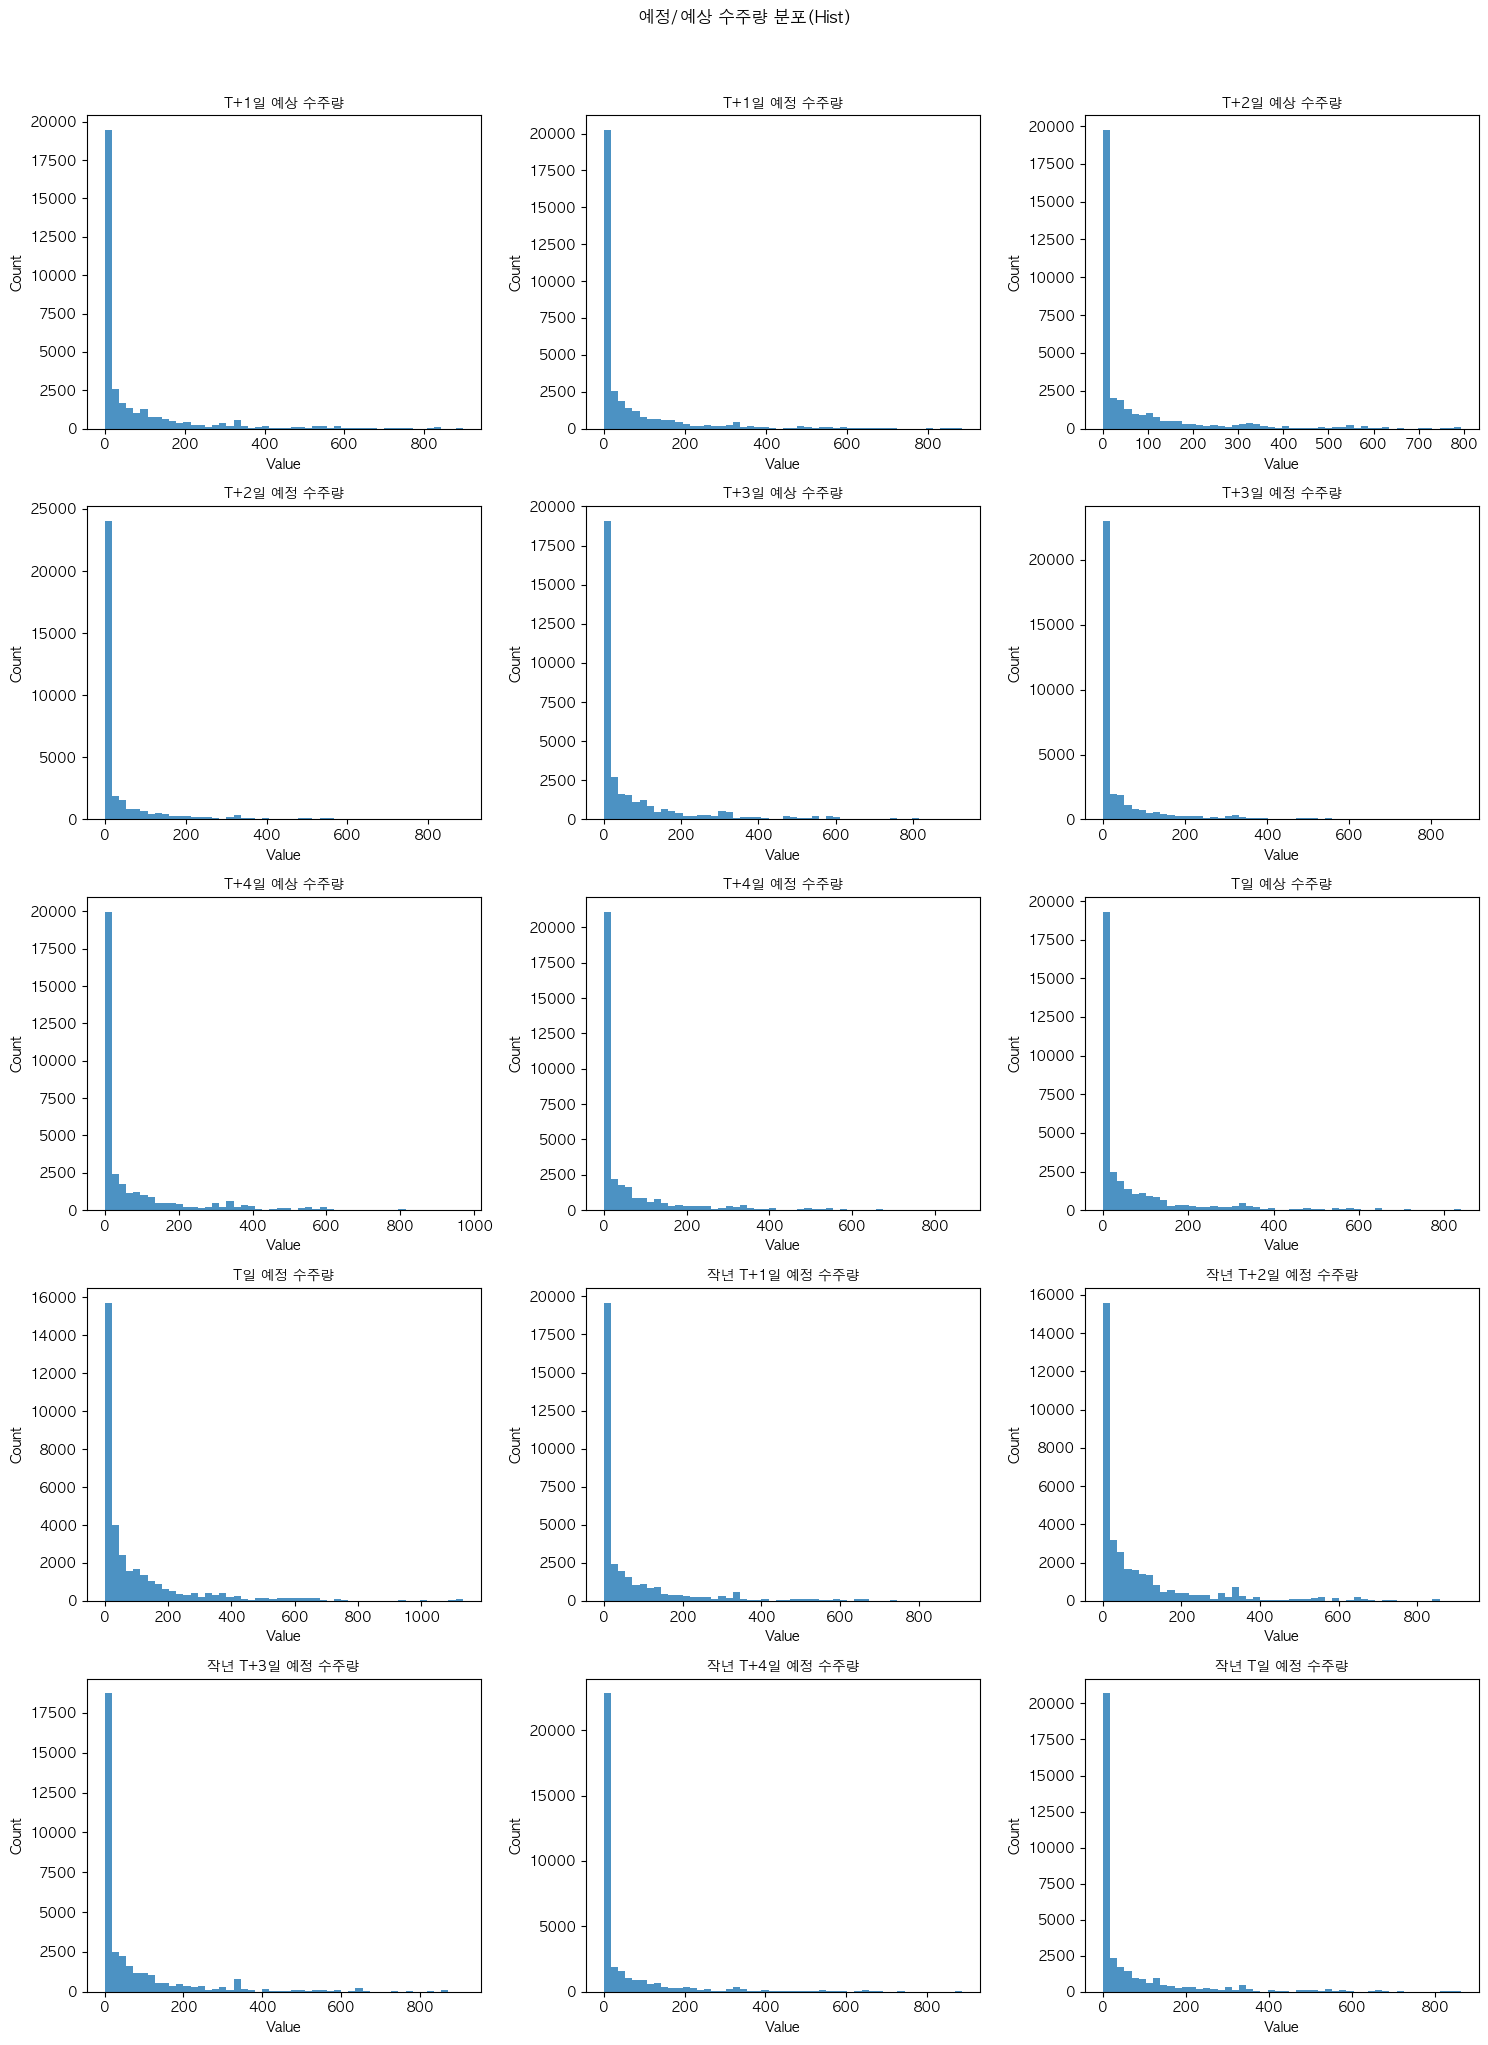

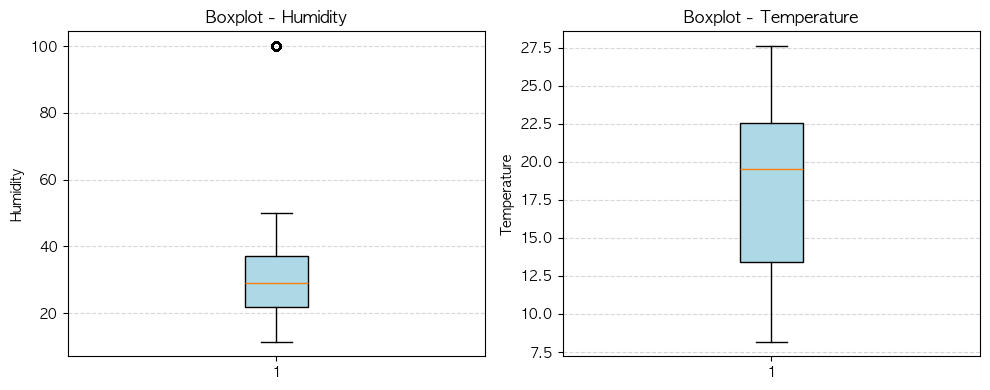

In [18]:
# =============================================
# 4) Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî (ÌûàÏä§ÌÜ†Í∑∏Îû® & Î∞ïÏä§ÌîåÎ°Ø)
# =============================================

# (A) ÌûàÏä§ÌÜ†Í∑∏Îû®: 'ÏòàÏ†ï ÏàòÏ£ºÎüâ' / 'ÏòàÏÉÅ ÏàòÏ£ºÎüâ' Ìè¨Ìï® Ïó¥
hist_cols = [c for c in df.columns if ("ÏòàÏ†ï ÏàòÏ£ºÎüâ" in c or "ÏòàÏÉÅ ÏàòÏ£ºÎüâ" in c)]
hist_cols = [c for c in hist_cols if pd.api.types.is_numeric_dtype(df[c])]
hist_cols = sorted(hist_cols)  # ÏùºÏ†ïÌïú ÏàúÏÑú

if hist_cols:
    n = len(hist_cols)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4*nrows))
    axes = np.array(axes).reshape(-1)  # ÏïàÏ†Ñ Î≥ÄÌôò
    for i, c in enumerate(hist_cols):
        axes[i].hist(df[c].dropna(), bins=50, alpha=0.8)
        axes[i].set_title(c, fontsize=10)
        axes[i].set_xlabel("Value"); axes[i].set_ylabel("Count")
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    fig.suptitle("ÏòàÏ†ï/ÏòàÏÉÅ ÏàòÏ£ºÎüâ Î∂ÑÌè¨(Hist)", y=1.02, fontsize=12)
    plt.tight_layout(); plt.show()
else:
    print("ÌûàÏä§ÌÜ†Í∑∏Îû® ÎåÄÏÉÅ Ïó¥Ïù¥ ÏóÜÏäµÎãàÎã§.")

# (B) Î∞ïÏä§ÌîåÎ°Ø: 1x2 Í∞ÄÎ°ú Î∞∞Ïπò
box_cols = [c for c in ["Humidity", "Temperature"] if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
if box_cols:
    fig, axes = plt.subplots(1, len(box_cols), figsize=(10, 4))
    if len(box_cols) == 1: axes = [axes]
    for ax, c in zip(axes, box_cols):
        ax.boxplot(df[c].dropna(), vert=True, patch_artist=True,
                   boxprops=dict(facecolor="lightblue"))
        ax.set_title(f"Boxplot - {c}")
        ax.set_ylabel(c); ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout(); plt.show()

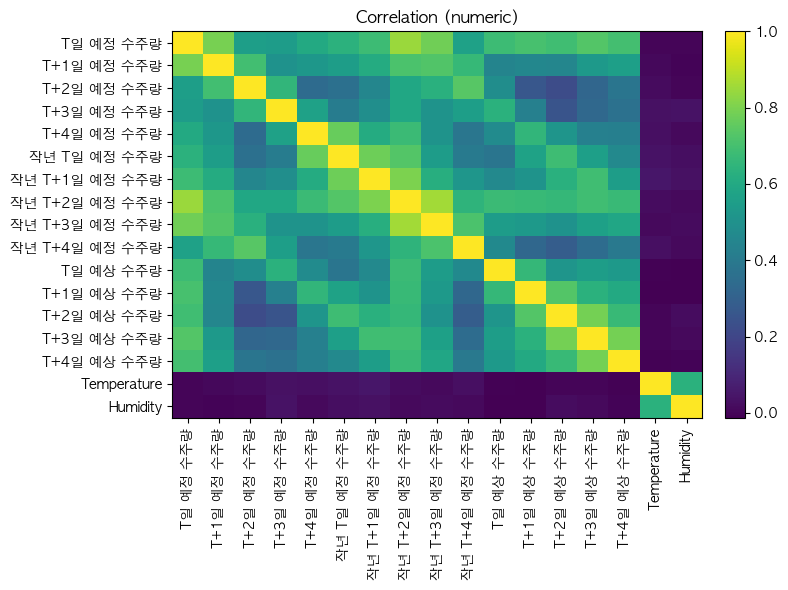

In [19]:
# =============================================
# 5) ÏÉÅÍ¥Ä ÌûàÌä∏Îßµ (ÏàòÏπòÌòï)
# =============================================
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
if len(num_cols) > 1:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr.values, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title("Correlation (numeric)")
    plt.tight_layout(); plt.show()

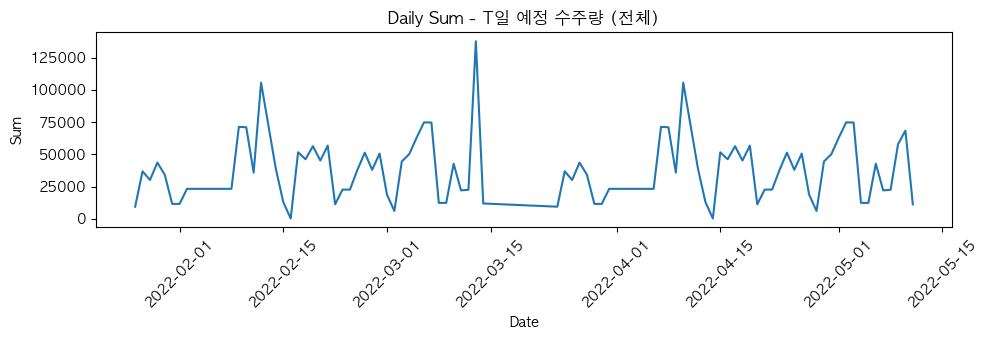

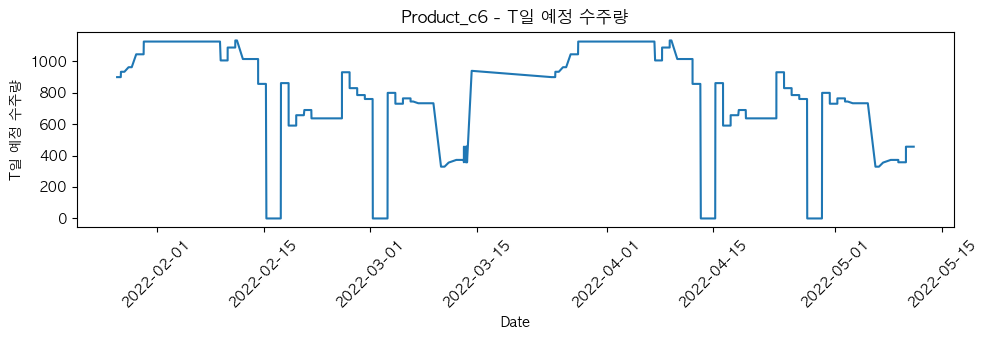

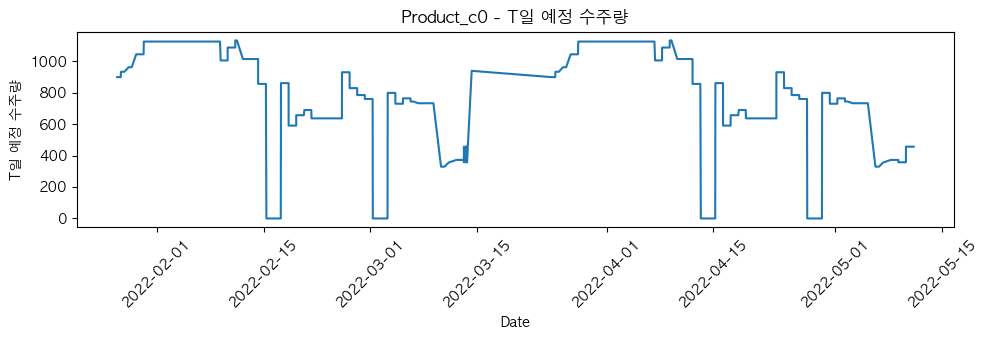

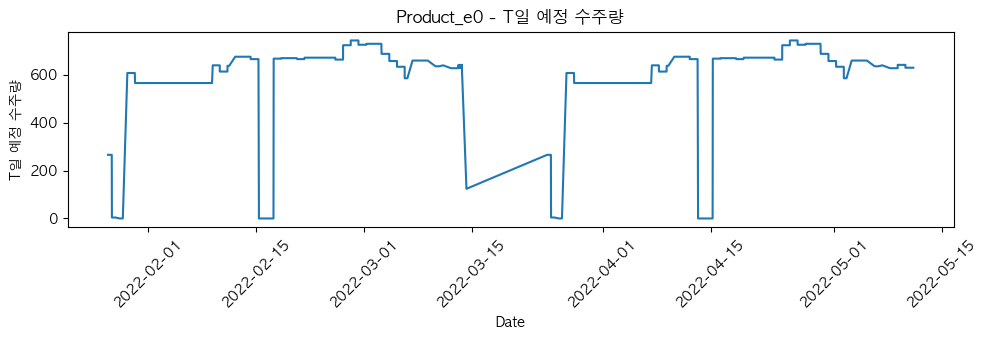

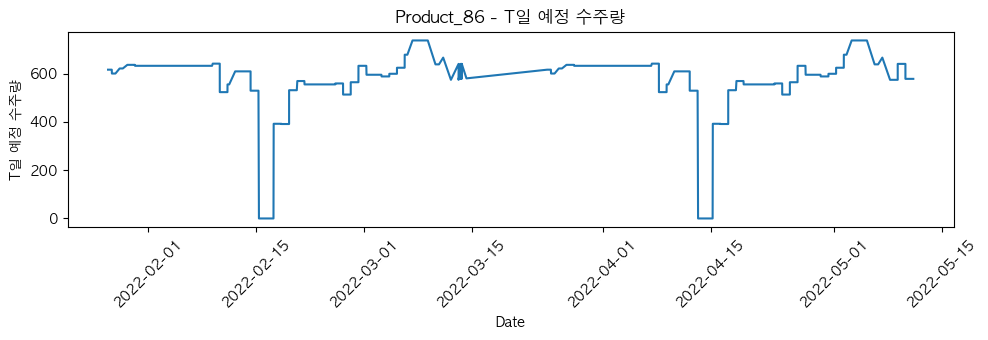

In [20]:
# =============================================
# 6) ÏãúÍ≥ÑÏó¥ Í∞úÏöî (Ï†ÑÏ≤¥/Top Ï†úÌíà)
# =============================================
if DT_COL in df.columns:
    # Ï†ÑÏ≤¥ Ìï©ÏÇ∞ (ÎåÄÌëú ÌÉÄÍπÉ ÏÑ†ÌÉù)
    cand = [c for c in ["TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ", "TÏùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ"] if c in df.columns]
    agg_target = cand[0] if cand else None

    if agg_target:
        daily = (df.groupby(df[DT_COL].dt.date)[agg_target]
                   .sum().sort_index())
        plt.figure(figsize=(10,3.5))
        plt.plot(daily.index, daily.values)
        plt.title(f"Daily Sum - {agg_target} (Ï†ÑÏ≤¥)")
        plt.xlabel("Date"); plt.ylabel("Sum")
        plt.xticks(rotation=45); plt.tight_layout(); plt.show()

        # ÏÉÅÏúÑ 4Í∞ú Ï†úÌíà Ï∂îÏÑ∏
        if PROD_COL in df.columns:
            top_prod = (df.groupby(PROD_COL)[agg_target]
                          .sum().sort_values(ascending=False).head(4).index.tolist())
            for p in top_prod:
                sub = df[df[PROD_COL] == p].sort_values(DT_COL)
                plt.figure(figsize=(10,3.5))
                plt.plot(sub[DT_COL], sub[agg_target])
                plt.title(f"{p} - {agg_target}")
                plt.xlabel("Date"); plt.ylabel(agg_target)
                plt.xticks(rotation=45); plt.tight_layout(); plt.show()

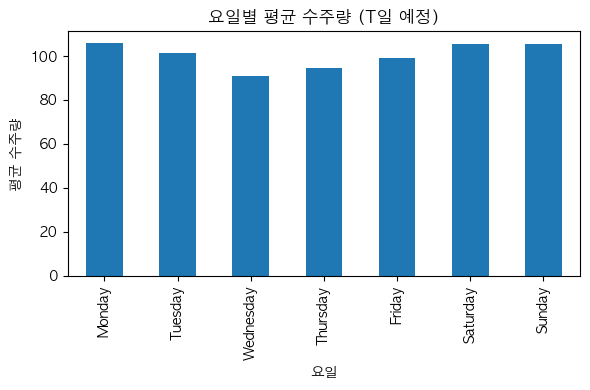

In [21]:
# =============================================
# 7) ÏöîÏùº Ìå®ÌÑ¥
# =============================================
if DT_COL in df.columns:
    df["DoW"] = df[DT_COL].dt.day_name()
    if "TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ" in df.columns:
        order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
        plt.figure(figsize=(6,4))
        (df.groupby("DoW")["TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ"].mean()
           .reindex(order)
           .plot(kind="bar"))
        plt.title("ÏöîÏùºÎ≥Ñ ÌèâÍ∑† ÏàòÏ£ºÎüâ (TÏùº ÏòàÏ†ï)")
        plt.xlabel("ÏöîÏùº"); plt.ylabel("ÌèâÍ∑† ÏàòÏ£ºÎüâ")
        plt.tight_layout(); plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2627
[LightGBM] [Info] Number of data points in the train set: 27693, number of used features: 12
[LightGBM] [Info] Start training from score 71.428845
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2723
[LightGBM] [Info] Number of data points in the train set: 27693, number of used features: 13
[LightGBM] [Info] Start training from score 71.428845
=== ÏÑ±Îä• ÎπÑÍµê (Test) ===
[Base] MAE=9.3461, RMSE=15.5315, R2=0.9862
[+Int] MAE=9.4858, RMSE=15.8153, R2=0.9857


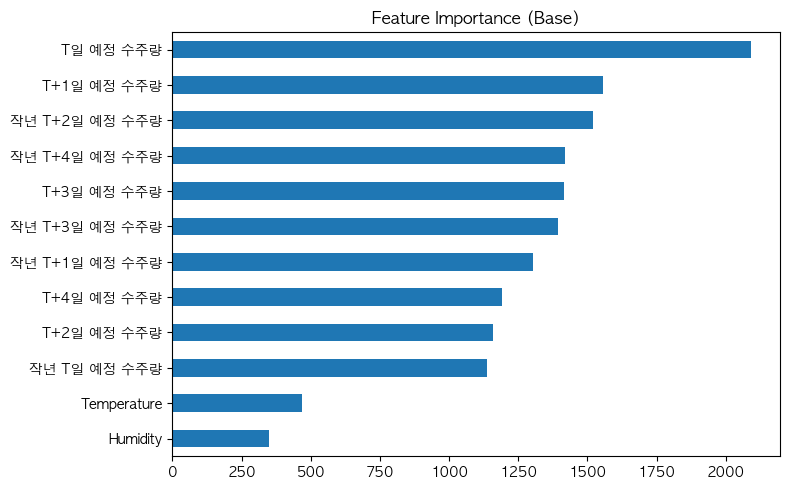

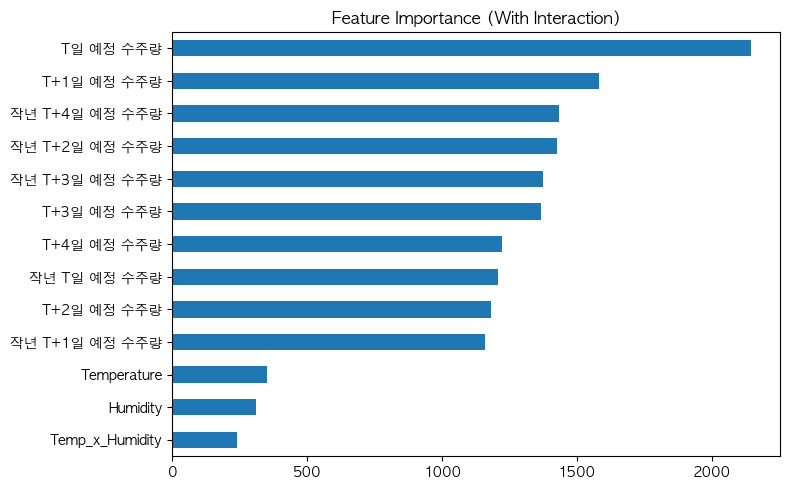

In [22]:
# =============================================
# 8) Í∞ÑÎã® ÌååÏÉù & LGBM Î≤†Ïù¥Ïä§ÎùºÏù∏ ÎπÑÍµê
# =============================================
# ÌÉÄÍπÉ
if "TÏùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ" in df.columns:
    target_col = "TÏùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ"
    # Í∏∞Î≥∏ ÌîºÏ≤ò(ÌÉÄÍπÉ/Ïú†ÏÇ¨ÌÉÄÍπÉ Ï†úÏô∏)
    base_num = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    feature_cols = [c for c in base_num if "ÏòàÏÉÅ ÏàòÏ£ºÎüâ" not in c]
    if target_col in feature_cols:
        feature_cols.remove(target_col)

    # Interaction
    if all(c in df.columns for c in ["Temperature", "Humidity"]):
        df["Temp_x_Humidity"] = df["Temperature"] * df["Humidity"]
    else:
        df["Temp_x_Humidity"] = 0.0

    feature_cols_int = list(dict.fromkeys(feature_cols + ["Temp_x_Humidity"]))

    def clean_X(X):
        X = X.loc[:, ~X.columns.duplicated()]
        return X.replace([np.inf, -np.inf], np.nan).fillna(0)

    X_base = clean_X(df[feature_cols].copy())
    X_int  = clean_X(df[feature_cols_int].copy())
    y = df[target_col]

    Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(X_base, y, test_size=0.2, random_state=42)
    Xi_tr, Xi_te, yi_tr, yi_te = train_test_split(X_int,  y, test_size=0.2, random_state=42)

    params = dict(n_estimators=500, learning_rate=0.05, subsample=0.8,
                  colsample_bytree=0.8, random_state=42, n_jobs=-1)
    model_base = lgb.LGBMRegressor(**params).fit(Xb_tr, yb_tr)
    model_int  = lgb.LGBMRegressor(**params).fit(Xi_tr, yi_tr)

    def evaluate(model, X, y):
        p = model.predict(X)
        return dict(MAE=mean_absolute_error(y, p),
                    RMSE=np.sqrt(mean_squared_error(y, p)),
                    R2=r2_score(y, p))

    res_base = evaluate(model_base, Xb_te, yb_te)
    res_int  = evaluate(model_int,  Xi_te, yi_te)
    print("=== ÏÑ±Îä• ÎπÑÍµê (Test) ===")
    print(f"[Base] MAE={res_base['MAE']:.4f}, RMSE={res_base['RMSE']:.4f}, R2={res_base['R2']:.4f}")
    print(f"[+Int] MAE={res_int['MAE']:.4f}, RMSE={res_int['RMSE']:.4f}, R2={res_int['R2']:.4f}")

    # Ï§ëÏöîÎèÑ Top15
    fi_base = pd.Series(model_base.feature_importances_, index=X_base.columns)
    fi_int  = pd.Series(model_int.feature_importances_,  index=X_int.columns)
    plt.figure(figsize=(8,5))
    fi_base.sort_values().tail(15).plot(kind="barh")
    plt.title("Feature Importance (Base)"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,5))
    fi_int.sort_values().tail(15).plot(kind="barh")
    plt.title("Feature Importance (With Interaction)"); plt.tight_layout(); plt.show()
else:
    print("Î™®Îç∏ ÎπÑÍµê Í±¥ÎÑàÎúÄ: 'TÏùº ÏòàÏÉÅ ÏàòÏ£ºÎüâ' ÏóÜÏùå")

üîπ Hour Í¥ÄÎ†® ÏÉÅÍ¥ÄÍ≥ÑÏàò:
Hour           1.000
Temperature    0.004
Humidity       0.015
TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ      0.011
Name: Hour, dtype: float64


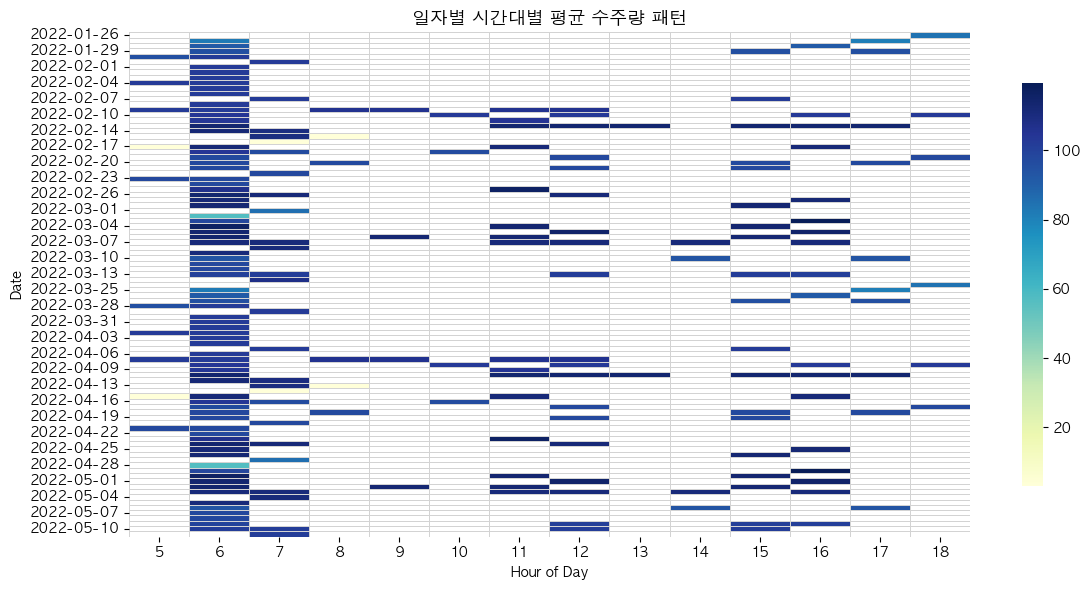

In [23]:
# 1) Hour ÌååÏÉùÎ≥ÄÏàò ÏÉùÏÑ±
if 'Hour' not in df.columns:
    df['Hour'] = df['DateTime'].dt.hour

# 2) ÏÉÅÍ¥ÄÍ≥ÑÏàò ÌôïÏù∏
corr_hour = df[['Hour', 'Temperature', 'Humidity', 'TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ']].corr()['Hour']
print("üîπ Hour Í¥ÄÎ†® ÏÉÅÍ¥ÄÍ≥ÑÏàò:")
print(corr_hour.round(3))

# 3) TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ Í∏∞Ï§Ä Heatmap
pivot = df.pivot_table(
    values='TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ',
    index=df['DateTime'].dt.date,
    columns='Hour',
    aggfunc='mean'  # ÌèâÍ∑† ÏàòÏ£ºÎüâ Í∏∞Ï§Ä
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot,
    cmap='YlGnBu',
    linewidths=0.5,
    linecolor='Lightgrey',
    cbar_kws={'shrink': 0.8}
)
plt.title("ÏùºÏûêÎ≥Ñ ÏãúÍ∞ÑÎåÄÎ≥Ñ ÌèâÍ∑† ÏàòÏ£ºÎüâ Ìå®ÌÑ¥", fontsize=13)
plt.xlabel("Hour of Day")
plt.ylabel("Date")
plt.tight_layout()
plt.show()

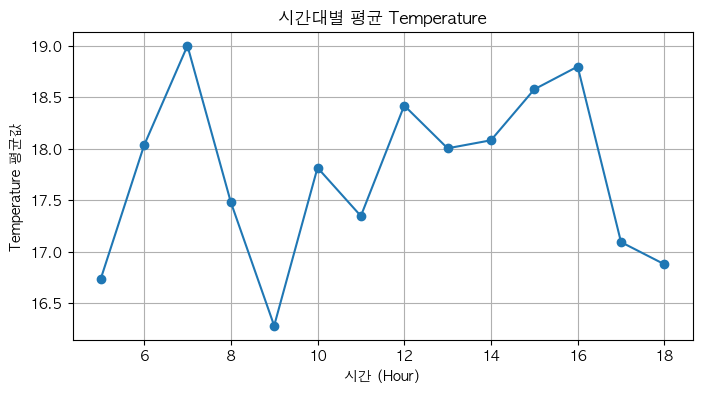

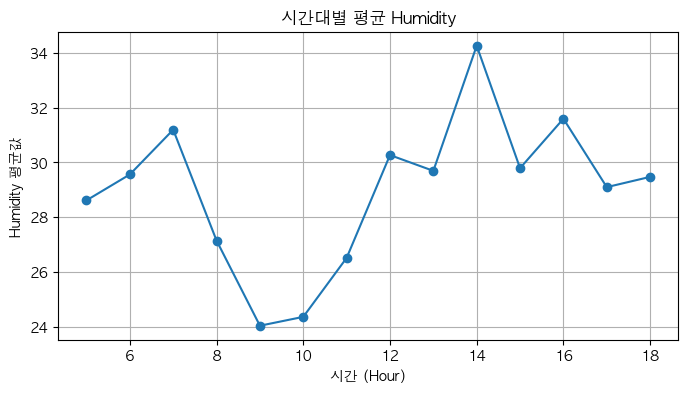

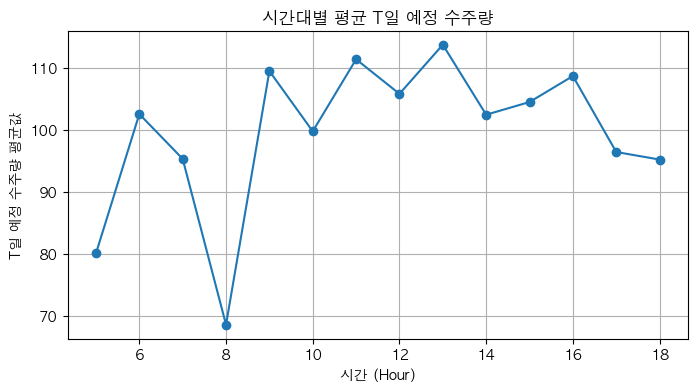

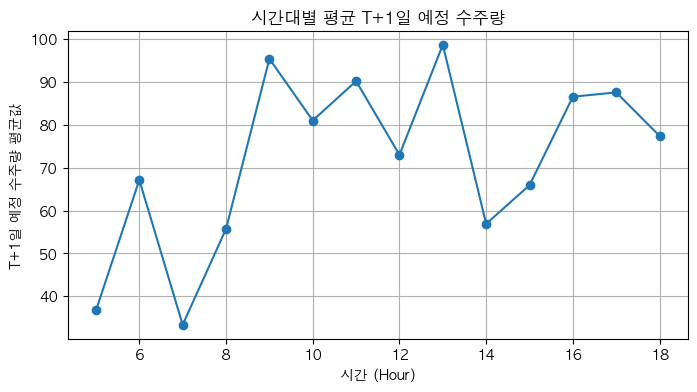

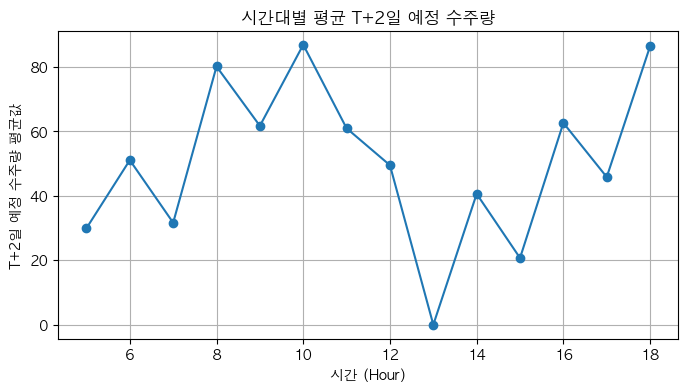

In [24]:
main_vars = ['Temperature', 'Humidity', 'TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ', 'T+1Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ', 'T+2Ïùº ÏòàÏ†ï ÏàòÏ£ºÎüâ']

for col in main_vars:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        df.groupby('Hour')[col].mean().plot(marker='o')
        plt.title(f'ÏãúÍ∞ÑÎåÄÎ≥Ñ ÌèâÍ∑† {col}')
        plt.xlabel('ÏãúÍ∞Ñ (Hour)')
        plt.ylabel(f'{col} ÌèâÍ∑†Í∞í')
        plt.grid(True)
        plt.show()

In [25]:
import scipy.stats as stats
groups = [g['TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ'].dropna() for _, g in df.groupby('Hour')]
f, p = stats.f_oneway(*groups)
print(f"(ÏàòÏ£ºÎüâ) ANOVA p-value: {p:.4f}")

groups = [g['Temperature'].dropna() for _, g in df.groupby('Hour')]
f, p = stats.f_oneway(*groups)
print(f"(Ïò®ÎèÑ) ANOVA p-value: {p:.4f}")

groups = [g['Humidity'].dropna() for _, g in df.groupby('Hour')]
f, p = stats.f_oneway(*groups)
print(f"(Ïò®ÎèÑ) ANOVA p-value: {p:.4f}")

(ÏàòÏ£ºÎüâ) ANOVA p-value: 0.0000
(Ïò®ÎèÑ) ANOVA p-value: 0.0000
(Ïò®ÎèÑ) ANOVA p-value: 0.0000


In [26]:
# ÏàòÏ£ºÎüâ-ÏãúÍ∞Ñ ÏÇ¨ÌõÑÎ∂ÑÏÑù
tukey = pairwise_tukeyhsd(
    endog=df['TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ'],
    groups=df['Hour'],
    alpha=0.05
)
print(tukey.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     5      6  22.5222 0.0009    5.361 39.6834   True
     5      7  15.2802 0.3053    -4.02 34.5804  False
     5      8 -11.5241 0.9792 -38.6446 15.5964  False
     5      9  29.4759 0.0927  -1.9383 60.8901  False
     5     10  19.7295 0.6806 -11.3385 50.7975  False
     5     11  31.3749    0.0  10.5837  52.166   True
     5     12  25.7879 0.0018   5.4097 46.1661   True
     5     13  33.7271 0.2288     -6.8 74.2541  False
     5     14  22.4158 0.4767  -8.8479 53.6795  False
     5     15  24.4653 0.0035   4.3849 44.5456   True
     5     16  28.6649 0.0003   7.8664 49.4635   True
     5     17  16.3875 0.5265  -7.1225 39.8976  False
     5     18   15.167 0.8418 -12.0029 42.3368  False
     6      7   -7.242 0.5795 -17.9548  3.4708  False
     6      8 -34.0464    0.0 -55.9047 -12.188   True
     6      9   6.9537 0.999

In [27]:
# Ïò®ÎèÑ-ÏãúÍ∞Ñ ÏÇ¨ÌõÑÎ∂ÑÏÑù
tukey = pairwise_tukeyhsd(
    endog=df['Temperature'],
    groups=df['Hour'],
    alpha=0.05
)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     5      6   1.2963    0.0  0.7657  1.8269   True
     5      7   2.2627    0.0   1.666  2.8594   True
     5      8   0.7449 0.1454 -0.0935  1.5834  False
     5      9  -0.4545  0.954 -1.4257  0.5168  False
     5     10   1.0789 0.0121  0.1184  2.0394   True
     5     11   0.6102 0.0835 -0.0326  1.2529  False
     5     12   1.6822    0.0  1.0522  2.3122   True
     5     13   1.2672 0.0443  0.0143  2.5202   True
     5     14   1.3451 0.0003  0.3785  2.3116   True
     5     15   1.8397    0.0  1.2189  2.4605   True
     5     16   2.0604    0.0  1.4173  2.7034   True
     5     17    0.357 0.9336 -0.3699  1.0838  False
     5     18   0.1419    1.0 -0.6981  0.9819  False
     6      7   0.9664    0.0  0.6352  1.2976   True
     6      8  -0.5514  0.258 -1.2271  0.1244  False
     6      9  -1.7508    0.0 -2.5856  -0.916 

In [28]:
# ÏäµÎèÑ-ÏãúÍ∞Ñ ÏÇ¨ÌõÑÎ∂ÑÏÑù
tukey = pairwise_tukeyhsd(
    endog=df['Humidity'],  # Ï¢ÖÏÜçÎ≥ÄÏàò
    groups=df['Hour'],             # ÏßëÎã®(ÏãúÍ∞ÑÎåÄ)
    alpha=0.05
)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     5      6   0.9439 0.2959 -0.2414  2.1293  False
     5      7   2.5747    0.0  1.2416  3.9078   True
     5      8  -1.4653 0.3251 -3.3386   0.408  False
     5      9  -4.5702    0.0   -6.74 -2.4003   True
     5     10  -4.2471    0.0  -6.393 -2.1011   True
     5     11   -2.098 0.0001 -3.5341 -0.6619   True
     5     12   1.6505 0.0065  0.2429  3.0581   True
     5     13   1.0757 0.9915 -1.7236   3.875  False
     5     14   5.6371    0.0  3.4777  7.7966   True
     5     15   1.1735 0.2058 -0.2135  2.5605  False
     5     16   2.9756    0.0   1.539  4.4122   True
     5     17    0.482 0.9994 -1.1419  2.1059  False
     5     18    0.856 0.9624 -1.0207  2.7327  False
     6      7   1.6307    0.0  0.8908  2.3707   True
     6      8  -2.4093    0.0 -3.9191 -0.8994   True
     6      9  -5.5141    0.0 -7.3792  -3.649 

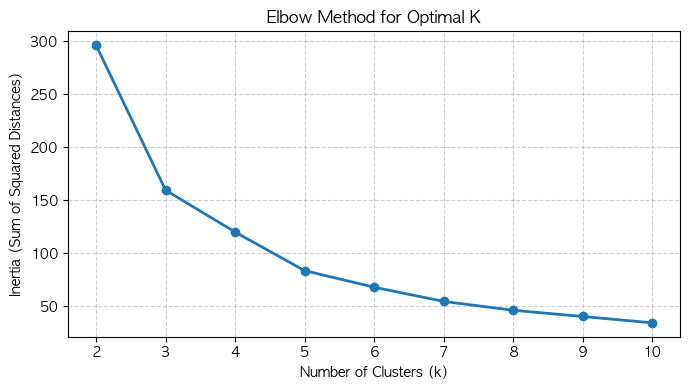

In [30]:
# =============================================
# 9) Ï†úÌíà Í∏∞Ï§Ä ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ
# =============================================
# Product Clustering (k=4 Í≥†Ï†ï)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ---- ÏÑ§Ï†ï ----
PROD_COL   = "Product_Number"
DT_COL     = "DateTime"
DEMAND_COL = "TÏùº ÏòàÏ†ï ÏàòÏ£ºÎüâ"
K_fixed    = 4  # Íµ∞Ïßë Í∞úÏàò Í≥†Ï†ï

# ---- ÏïàÏ†Ñ Í∞ÄÎìú ----
assert PROD_COL in df.columns, f"'{PROD_COL}' Ïª¨ÎüºÏù¥ ÌïÑÏöîÌï©ÎãàÎã§."
assert DT_COL   in df.columns, f"'{DT_COL}' Ïª¨ÎüºÏù¥ ÌïÑÏöîÌï©ÎãàÎã§."
assert DEMAND_COL in df.columns, f"'{DEMAND_COL}' Ïª¨ÎüºÏù¥ ÌïÑÏöîÌï©ÎãàÎã§."

# ÎÇ†ÏßúÌòï
df = df.copy()
df[DT_COL] = pd.to_datetime(df[DT_COL], errors="coerce")

# Ïà´ÏûêÌòï Î≥ÄÌôò(ÏΩ§Îßà/Î¨∏Ïûê ÎåÄÎπÑ)
df[DEMAND_COL] = pd.to_numeric(df[DEMAND_COL].astype(str).str.replace(",", ""), errors="coerce").fillna(0.0)

# 1) Ï†úÌíàÎ≥Ñ ÌÜµÍ≥Ñ ÌîºÏ≤ò ÏÉùÏÑ±
g = df.groupby(PROD_COL)[DEMAND_COL]
product_features = pd.DataFrame({
    "Mean_Demand": g.mean(),
    "Std_Demand":  g.std(ddof=1),
    "Zero_Ratio":  g.apply(lambda x: (x == 0).mean())
})
# CV = std / mean (mean=0 ‚Üí 0)
mean_safe = product_features["Mean_Demand"].replace(0, np.nan)
product_features["CV_Ratio"] = (product_features["Std_Demand"] / mean_safe) \
                                   .replace([np.inf, -np.inf], np.nan).fillna(0.0)
product_features = product_features.fillna(0.0)

# 2) ÌëúÏ§ÄÌôî
Xs = StandardScaler().fit_transform(product_features.values)

# 3) Elbow Method (Ï†ÅÏ†ï K ÌÉêÏÉâ)
inertias = []
K_range = range(2, 11)  # k ÌõÑÎ≥¥ Î≤îÏúÑ (2~10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(Xs)
    inertias.append(model.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K_range, inertias, marker='o', linewidth=2)
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


--- 1) Ï†úÌíà ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥º (Í∞úÏàò) ---
Cluster
1    72
3    24
0    15
2     6

--- 2) ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌèâÍ∑† ÌîºÏ≤ò ---
         Mean_Demand  Std_Demand  Zero_Ratio  CV_Ratio
Cluster                                               
0            420.889     140.465       0.048     0.372
1             63.648      33.354       0.097     0.691
2              0.441       1.581       0.894     4.127
3              5.738       9.183       0.525     1.559


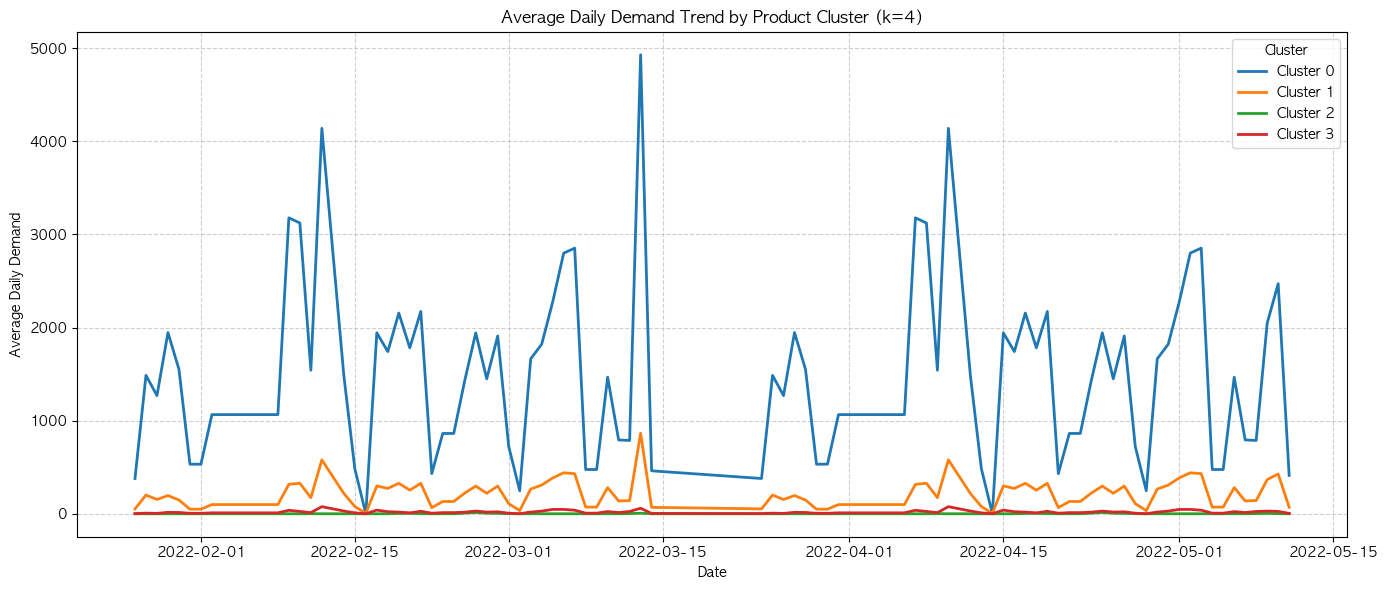

In [31]:
# 4) KMeans (k=4 Í≥†Ï†ï)
kmeans = KMeans(n_clusters=K_fixed, random_state=42, n_init=10)
labels = kmeans.fit_predict(Xs)
product_features["Cluster"] = labels

print("\n--- 1) Ï†úÌíà ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥º (Í∞úÏàò) ---")
print(product_features["Cluster"].value_counts().to_string())

print("\n--- 2) ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌèâÍ∑† ÌîºÏ≤ò ---")
print(
    product_features.groupby("Cluster")[["Mean_Demand","Std_Demand","Zero_Ratio","CV_Ratio"]]
    .mean()
    .round(3)
    .to_string()
)

# 5) ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌèâÍ∑† ÏùºÎ≥Ñ ÏàòÏöî ÏãúÍ≥ÑÏó¥
df["Date"] = df[DT_COL].dt.date
daily = df.pivot_table(index="Date", columns=PROD_COL, values=DEMAND_COL, aggfunc="sum").fillna(0.0)

cluster_map = product_features["Cluster"].to_dict()
valid_cols = [c for c in daily.columns if c in cluster_map]
daily = daily[valid_cols]

cluster_ts = pd.DataFrame(index=daily.index)
for c in sorted(product_features["Cluster"].unique()):
    prods = [p for p, lab in cluster_map.items() if lab == c and p in daily.columns]
    if prods:
        cluster_ts[f"Cluster {c}"] = daily[prods].mean(axis=1)

# 6) ÏãúÍ∞ÅÌôî
plt.figure(figsize=(14, 6))
cluster_ts.plot(ax=plt.gca(), linewidth=2)
plt.title("Average Daily Demand Trend by Product Cluster (k=4)")
plt.xlabel("Date"); plt.ylabel("Average Daily Demand")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()